In [16]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import optimize
from scipy.signal import savgol_filter
from scipy.integrate import cumulative_trapezoid
import scipy.constants as scc

In [12]:
# load data
save_path = '../data/results.npz'
loaded_data = np.load(save_path)
f_SiSi3 = loaded_data['f_SiSi3']
f_SiO3 = loaded_data['f_SiO3']
f_OO3 = loaded_data['f_OO3']

In [5]:
delta_r = 0.02  # unit is A
r_max = 8+delta_r
r = np.arange(delta_r, r_max, delta_r)
R = r[1:] - delta_r / 2

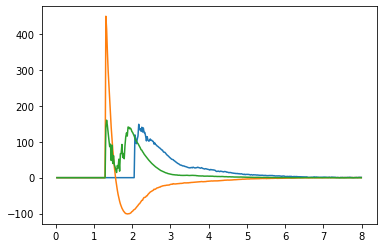

In [13]:
plt.plot(R,f_SiSi3)
plt.plot(R,f_SiO3)
plt.plot(R,f_OO3)

In [38]:
kcalpermole2ev = 1000*scc.calorie/scc.Avogadro/scc.electron_volt
# Buckingham + Coulomb 
def Buckingham_Coulomb_force(r,qq,A,B,C):
    """
    force form, unit = kcal/mol/A
    This form is the same as the BKS potential, qq unit: e2, A unit: eV, B: 1/A, C: eV*A6
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + A*B*np.exp(-B*r) /kcalpermole2ev 
            - 6*C/r**7 /kcalpermole2ev) # + 4*D*((12)*E**12/r**12/kcalpermole2ev)

def Morse_Coulomb_force(r,qq,De,a,re):
    """
    force form (Morse), unit = kcal/mol/A
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )


def LJ_Coulomb_force(r,qq,epsilon,sigma):
    """
    force form (Morse), unit = kcal/mol/A
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + 4*epsilon*(12*(sigma/r)**13-6*(sigma/r)**7)  )

q_Si_list = np.arange(0.4,1.4,0.1)
loss_list = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi = optimize.curve_fit(Buckingham_Coulomb_force, xfit, yfit, p0=[qf_Si**2,1388,3,175],bounds=([qf_Si**2-1e-8,0,0,0],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO = optimize.curve_fit(Buckingham_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO = optimize.curve_fit(Buckingham_Coulomb_force, xfit, yfit, p0=[qf_O**2,1388,4,300],bounds=([qf_O**2-1e-8,0,0,0],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]

    # print(params_SiSi,params_SiO,params_OO)
    
    # considering the error at the large distances that are more risky (more interaction pairs at large distances)
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Buckingham_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Buckingham_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Buckingham_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list.append(loss)

loss_list_Morse = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_Si**2,-1,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,1e8,1e8,1e8]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,-1,1,1],bounds=([qf_O*qf_Si-1e-8,-1e8,-1e8,-1e8],[qf_O*qf_Si,1e8,1e8,1e8]),maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_O**2,-1,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8,-1e8],[qf_O**2,1e8,1e8,1e8]),maxfev=1000000)[0]
    
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi_Morse)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO_Morse)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO_Morse)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list_Morse.append(loss)

loss_list_LJ = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_Si**2,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8],[qf_Si**2,1e8,1e8]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,1,1],bounds=([qf_O*qf_Si-1e-8,-1e8,-1e8],[qf_O*qf_Si,1e8,1e8]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O**2,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8],[qf_O**2,1e8,1e8]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]
    
    # print(params_SiSi,params_SiO,params_OO)
    
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi_LJ)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO_LJ)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO_LJ)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list_LJ.append(loss)


<ipython-input-38-2dcfaa8eaf9c>:17: RuntimeWarning: overflow encountered in exp
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )
<ipython-input-38-2dcfaa8eaf9c>:17: RuntimeWarning: overflow encountered in multiply
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )


charge of Si with minimum loss = 0.80
charge of Si with minimum loss = 0.90
charge of Si with minimum loss = 0.90


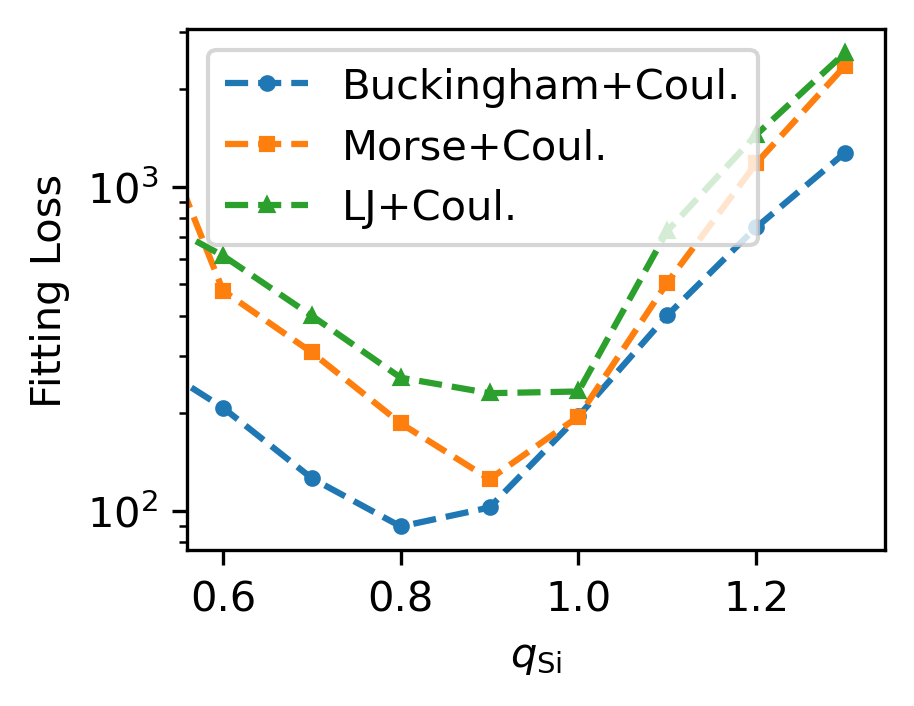

In [39]:
plt.figure(dpi=300,figsize=[3,2.3])
plt.semilogy(q_Si_list,np.array(loss_list)/405,'--o',ms=3,label='Buckingham+Coul.')
plt.plot(q_Si_list,np.array(loss_list_Morse)/405,'--s',ms=3,label='Morse+Coul.')
plt.plot(q_Si_list,np.array(loss_list_LJ)/405,'--^',ms=3,label='LJ+Coul.')

plt.ylabel('Fitting Loss') # r'$\sum_{r_{\alpha \beta,i}}||f_{fit}-f_{FM}||^2/\sum_{r_{\alpha \beta,i}} 1$'
plt.xlabel('$q_\mathrm{Si}$')
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list))]))
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list_Morse))]))
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list_LJ))]))
plt.xlim(0.56)
plt.legend()